In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import warnings
import pandas as pd
import datetime as dt
from datetime import timedelta

In [3]:
#see the following StackOverflow page for details about this section: 
    #https://stackoverflow.com/questions/40659212/futurewarning-elementwise-comparison-failed-returning-scalar-but-in-the-futur
warnings.simplefilter(action='ignore', category=FutureWarning)
print('x' in np.arange(5))   #returns False, without Warning

False


# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
conn = engine.connect()

In [6]:
# reflect an existing database into a new model
# reflect the tables
Base = automap_base()
Base.prepare(engine, reflect=True)

In [7]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)
inspector = inspect(engine)

# Exploratory Precipitation Analysis

In [10]:
# Find the most recent date in the data set.
session.query(Measurement.date).order_by(Measurement.date).first()

('2010-01-01')

The most recent date in this dataset is ('2017-08-23',).
One year prior to the most recent date in this dataset is 2016-08-23.
           station        date  prcp  tobs
id                                        
8825   USC00517948  2016-08-23   NaN  80.0
2364   USC00519397  2016-08-23  0.00  81.0
19202  USC00516128  2016-08-23  0.70  74.0
14608  USC00519281  2016-08-23  1.79  77.0
11851  USC00519523  2016-08-23  0.02  80.0
...            ...         ...   ...   ...
19549  USC00516128  2017-08-22  0.50  76.0
2724   USC00519397  2017-08-23  0.00  81.0
7635   USC00514830  2017-08-23  0.00  82.0
12187  USC00519523  2017-08-23  0.08  82.0
19550  USC00516128  2017-08-23  0.45  76.0

[2230 rows x 4 columns]


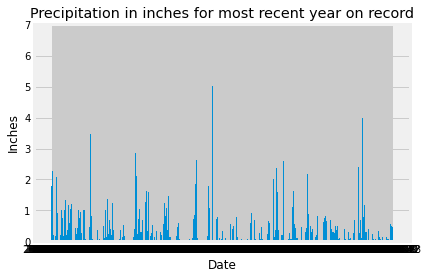

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 

# Starting from the most recent data point in the database. 
startDate = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(f'The most recent date in this dataset is {startDate}.')

# Calculate the date one year from the last date in data set.
pastYear = dt.date(2017, 8, 23) - dt.timedelta(days=365)
print(f'One year prior to the most recent date in this dataset is {pastYear}.')

# Perform a query to retrieve the data and precipitation scores
df = pd.DataFrame(engine.execute('SELECT * FROM Measurement').fetchall())

# Save the query results as a Pandas DataFrame and set the index to the date column
# Sort the dataframe by date
df = df.rename(columns={0:"id", 1:"station", 2:"date", 3: "prcp", 4:"tobs"}).set_index('id').sort_values('date')
df = df[(df['date'] >= '2016-08-23')]
sp_df = df.drop(['tobs', 'station'], axis=1)
print(df)

# Use Pandas Plotting with Matplotlib to plot the data

plt.bar(sp_df['date'], df['prcp'])
plt.xlabel("Date")
plt.ylabel("Inches")
plt.title("Precipitation in inches for most recent year on record")
plt.show()

In [12]:
# Use Pandas to calcualte the summary statistics for the precipitation data
sumstat = pd.DataFrame(df['prcp'].describe())
sumstat

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [13]:
# Design a query to calculate the total number stations in the dataset
stationcount = pd.DataFrame(engine.execute('SELECT COUNT(station) FROM station').fetchall())
stations_count = stationcount.iloc[0,0]
print(f'There are {stations_count} stations in the dataset.')

There are 9 stations in the dataset.


In [14]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.

ms_df = pd.read_sql('Select * from Measurement', conn)
ms_df['total'] = 1
activeStation_df = ms_df.groupby(['station']).sum().sort_values(by='total', ascending=False).reset_index()
mostActiveStation = activeStation_df.iloc[0,0]
print(f'The most active station in the dataset is {mostActiveStation}.')

# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
activeStationInfo = ms_df.loc[ms_df['station'] == 'USC00519281']
activeStationInfo = activeStationInfo.drop(['total'], axis=1)
activeStationInfo = activeStationInfo.describe()
mintemp = activeStationInfo.iloc[3,2]
maxtemp = activeStationInfo.iloc[7,2]
avtemp = round(activeStationInfo.iloc[1,2], 1)

print(f'The lowest temperature recorded at station {mostActiveStation} was {mintemp}.')
print(f'The highest temperature recorded at station {mostActiveStation} was {maxtemp}.')
print(f'The approximate average temperature recorded at station {mostActiveStation} was {avtemp}.')

The most active station in the dataset is USC00519281.
The lowest temperature recorded at station USC00519281 was 54.0.
The highest temperature recorded at station USC00519281 was 85.0.
The approximate average temperature recorded at station USC00519281 was 71.7.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002B29DF67710>]],
      dtype=object)

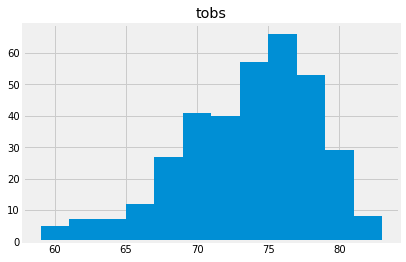

In [15]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

new_df = df.loc[df['station'] == 'USC00519281']
new_df = new_df.drop(['prcp', 'station'], axis=1)
hist = new_df.hist(bins=12)
hist

# Close session

In [16]:
# Close Session
session.close()